# Time Series Analysis - Part 2 :  Auto Regressive(AR) and  Moving Average(MA)

In the previous sheet, we talked about the basics of time series analysis and discussed basic conecpts like Staionarity and AutoCorrelation. We also talked about simple time series models, White Noise and Random Walks. 

In this notebook, we take the concept forward and introduce more sophisticated time series models, namely Auto Regressive(AR), Moving Average(MA).


In [7]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [8]:
import pandas_datareader.data as web
from datetime import datetime

start = datetime(2015, 1, 1)
end = datetime(2018, 8, 1)

symbols = ['AAPL','GOOG','MSFT','SPXC']

def get_data(symbols, start, end):
    ts = []
    for symbol in symbols:
        ts.append(web.DataReader(symbol, 'iex', start, end)['close'])
    data = pd.concat(ts, axis = 1)
    data.columns=symbols
    data = data.rename(index = \
                   {i: pd.datetime(int(i[:4]), int(i[5:7]), int(i[8:10])) for i in data.index.values.tolist()})
    return data
data = get_data(symbols, start, end)
data.head()

,AAPL,GOOG,MSFT,SPXC
date,,,,
2015-01-02,102.3192,524.81,42.7839,337.7475
2015-01-05,99.4367,513.87,42.3859,323.6272
2015-01-06,99.4461,501.96,41.7683,317.8453
2015-01-07,100.8406,501.10,42.2990,317.8060
2015-01-08,104.7151,502.68,43.5433,324.2172


In [9]:
lrets = np.log(data/data.shift(1)).dropna()

In [10]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

### Autoregressive Models of order p $AR(p)$

The autoregressive model is simply an extension of the random walk. It is essentially a regression model which depends linearly on the previous terms:
$$x_t = \alpha_1x_{t-1}+…+\alpha_px_{t-p}+w_t = \sum_{i=1}^{p}\alpha_ix_{t-i}+w_t$$

This is an AR model of order "p",where $p$ represents the number of previous (or lagged) terms used within the model, $\alpha_i$ is the coefficient, and $w_t$ is a white noise term. Note that an AR(1) model with $\alpha_1$ set equal to 1 is a random walk!

One of the most important aspects of the AR(p) model is that it is not always stationary. The stationarity of a particular model depends upon the parameters. For example, an AR(1) model with $\alpha_1$ = 1 is a random walk and therefore not stationary.

Let's simulate an AR(1) model with $\alpha$ set equal to 0.6

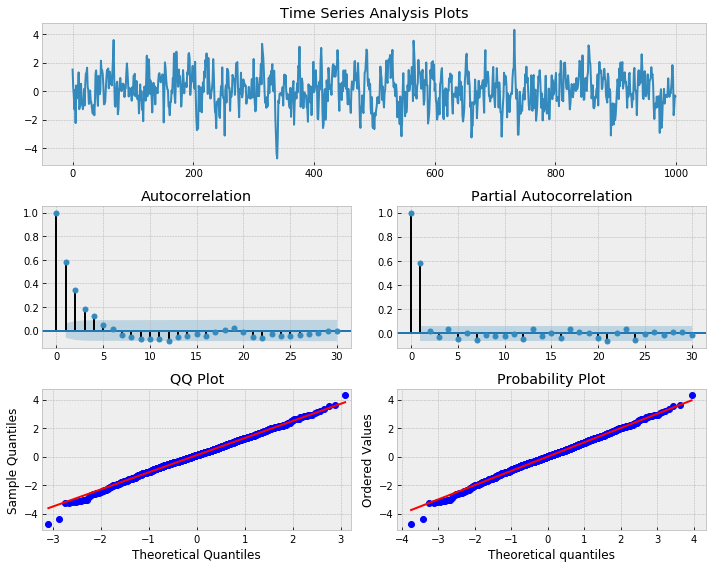

In [11]:
# Simulate an AR(1) process with a = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]

_ = tsplot(x, lags=30)

Note the distribution of our simulated AR(1) model is normal but there is significant serial correlation between lagged values visible in the ACF and PACF plots.

PACF plots are used to identify the extent of the lag in an autoregressive mode. If we find no significant correlation in a PACF plot after lag $k$, an AR(k) model is usually a good fit. Looking at this chart, we can hypothesize that a AR(1) model should fit.


#### Data Fitting
Now we can fit an AR(p) model using Python's statsmodels to estimate the alpha coefficient and order. If the AR model is correct the estimated alpha coefficient will be close to our true alpha of 0.6 and the selected order will equal 1.

In [12]:
help(sm.tsa.AR)

Help on class AR in module statsmodels.tsa.ar_model:

class AR(statsmodels.tsa.base.tsa_model.TimeSeriesModel)
 |  Autoregressive AR(p) model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      1-d endogenous response variable. The independent variable.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  missing : str
 |      Available options are 'none', 'drop', and 'raise'. If 'none', no nan
 |      checking is done. If 'drop', any observations with nans are dropped.
 |      If 'raise', an error is raised. Default is 'none.'
 |  
 |  Method resolution order:
 |      AR
 |      statsmodels.tsa.base.tsa_model.TimeSeriesModel
 |      statsmodels.base.model.LikelihoodModel
 |   

In [14]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = sm.tsa.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = sm.tsa.AR(x).select_order( maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: %3.5f | order_estimate %s'%(mdl.params, est_order))
print('\ntrue alpha = %s | true order = %s'%(a, true_order))


alpha estimate: 0.58227 | order_estimate 1

true alpha = 0.6 | true order = 1


Looks like we were able to recover the underlying parameters of our simulated data. 

Let's simulate an AR(2) process with $\alpha_1$ = 0.666 and $\alpha_2$ = -0.333. 

In [16]:
#np.r_[1, -alphas]

In [18]:
#help(np.r_)

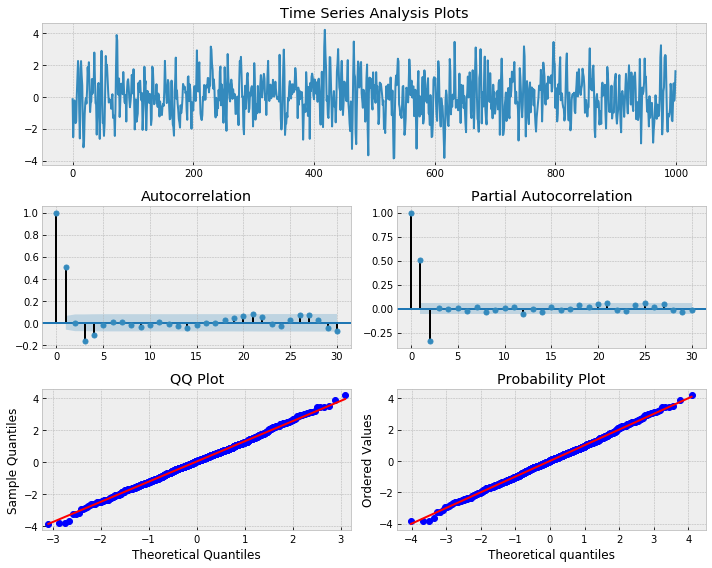

In [19]:
# Simulate an AR(2) process
n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30)

In [26]:
#ar2

There is significant serial correlation between lagged values at lag 1 and 2 now, as evidenced by the PACF plot.Let's see if we recover the underlying parameters of our simulated data. 

In [27]:
# Fit an AR(p) model to simulated AR(2) process
max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order( maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: %3.4f %3.4f | order estimate %s'%(mdl.params[0],mdl.params[1],est_order))


coef estimate: 0.6760 -0.3393 | order estimate 2


### Note on choosing the number of lags

If we just naively fit a model, it will estimate quite a few parameters. See below

In [49]:
mdl = smt.AR(ar2).fit()
print('Parameters')
print(mdl.params)
print('Standard Error')
print(mdl.bse)

'''
# Fit an AR(p) model to simulated AR(2) process
max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order( maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: %3.4f %3.4f | order estimate: %s'%(mdl.params[0],mdl.params[1],est_order))
'''

Parameters
[-0.02227616  0.64387116 -0.34470739  0.02997297 -0.00467016 -0.01071206
  0.06784549 -0.07814879  0.06668177 -0.04160198 -0.0023792   0.06168267
 -0.04514181  0.04966771 -0.06173522  0.00155971  0.04762044 -0.11501266
  0.08610252 -0.03906752 -0.02337093 -0.02330658]
Standard Error
[0.03114438 0.03231684 0.03843015 0.03997734 0.03986937 0.03961235
 0.03958858 0.03966544 0.03969309 0.03968392 0.03965581 0.03956501
 0.03962163 0.03962297 0.03961884 0.0395783  0.03950395 0.03945308
 0.03963723 0.03972822 0.03824322 0.03223757]


"\n# Fit an AR(p) model to simulated AR(2) process\nmax_lag = 10\nmdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')\nest_order = smt.AR(ar2).select_order( maxlag=max_lag, ic='aic', trend='nc')\n\ntrue_order = 2\nprint('\ncoef estimate: %3.4f %3.4f | order estimate: %s'%(mdl.params[0],mdl.params[1],est_order))\n"

In this case we know there are too many because we simulated the data as an AR(2) process. 

AR models will estimate many more lags than is actually the case is due to indirect dependency - if $X_t$ depends on  $X_{t−1}$ which depends on $X_{t−2}$, then indirectly $X_t$ it will depend on  $X_{t−2}$ . In the presence of more than one lag indirect dependencies will be picked up by a simple estimation.

However, we want the fewest parameters that yield a good model, that explain what is happening. Any additional and unwanted parameters will lead to Overfitting.

Observing the ACF and PACF indicates that only the first 2 lags may be useful. However, we will empericially test the number of lags by using some form if information criterion(specifically [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion)). Python does this for us when we specify 'maxlag' and 'ic' to the fit function. To try it yourself, compute the AIC for all models we wish to consider, and note the smallest AIC. This model minimizes information loss and gives the best number of parameters

In [21]:
N = 10
AIC = np.zeros((N, 1))
AIC

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [28]:
for i in range(N):
    model = smt.AR(ar2)
    model = model.fit(maxlag=(i+1))
    AIC[i] = model.aic
AIC

array([[0.18855675],
       [0.06334307],
       [0.06608118],
       [0.06896158],
       [0.06974896],
       [0.07142829],
       [0.07361059],
       [0.07502689],
       [0.07765342],
       [0.0787022 ]])

In [29]:
AIC_min = np.min(AIC)
model_min = np.argmin(AIC)
print('Number of parameters in minimum AIC model %s' % (model_min+1))

Number of parameters in minimum AIC model 2


### Evaluating Residuals
The final step after fitting our model is to evaluate its residual behavior. Rememeber we mentioned earlier that our aim is to find a model fit for our time series such that the residuals are white noise.

Let's check for normality of the residuals here.

In [30]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

The residuals seem normally distributed.


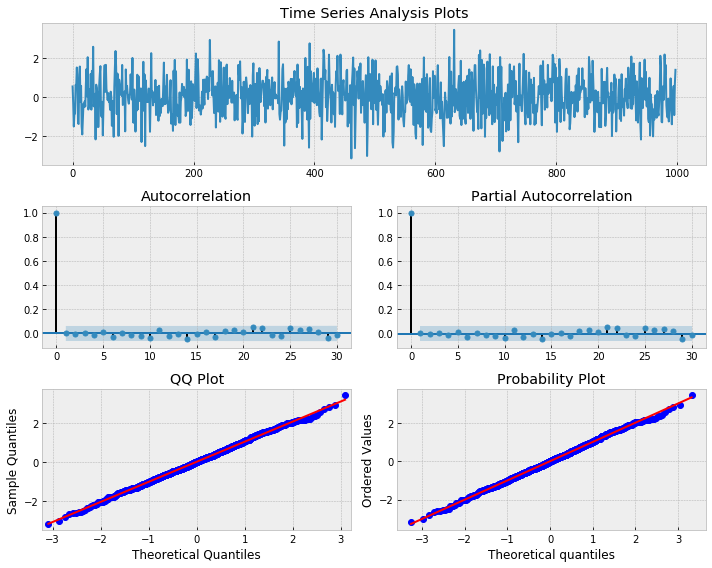

In [31]:
tsplot(mdl.resid, lags=30)

The residuals indeed look like white noise, indicating we have explained the data well with our model

#### Side Note: Fat Tails

Autoregressive processes are more likely to have extreme values than data drawn from a normal distribution. Since the value at each time point is influenced by recent values, if the series randomly jumps up, it is more likely to stay up than a non-autoregressive series. This is known as fat-tailed distribution because the tails (extremes) on PDF will be fatter than in a normal distribution.

AR models are just one of the sources of tail risk, so don't assume that because a series is non-AR, it does not have tail risk.

#### Application to Financial Series

Now let's see how the AR(p) model will fit AAPL log returns. Here is the log returns TS.

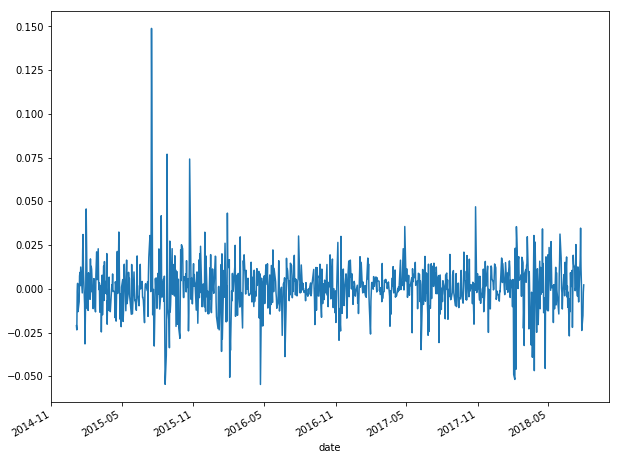

In [32]:
lrets.GOOG.plot(figsize=(10, 8))

Let's find the best order and also plot the residuals of the model

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best estimated lag order = 9


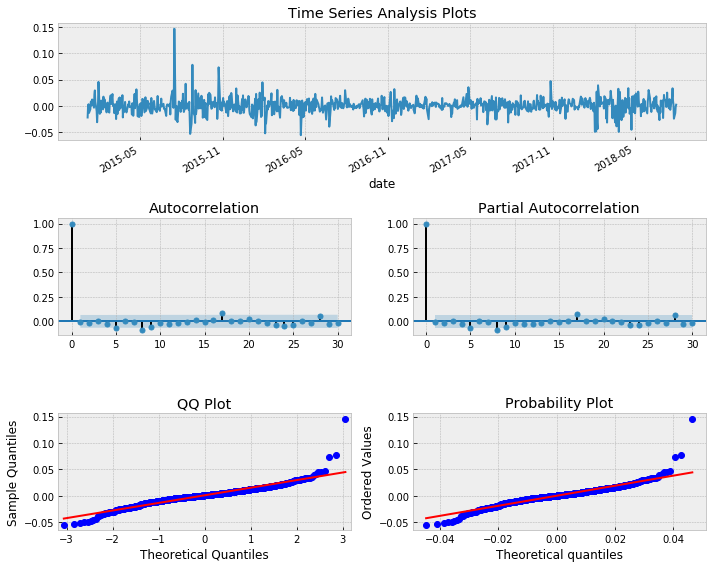

In [33]:
# Select best lag order for AAPL returns

max_lag = 30
mdl = smt.AR(lrets.GOOG).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.GOOG).select_order(maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = %s'%(est_order))

_ = tsplot(mdl.resid, lags=max_lag)

This produces an AR(9) model, i.e. a model with 9 non-zero parameters! You can see the non-significant peak at k=16 in the ACFplot of the residuals.

What does this tell us? It is indicative that there is likely a lot more complexity in the serial correlation than a simple linear model of past prices can really account for. A test of normality on model residuals indicates the same.

In [71]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

We have reason to suspect the residuals are not normally distributed.


Finally let's see how the AR(p) model will fit AAPL log returns. Here is the log returns TS

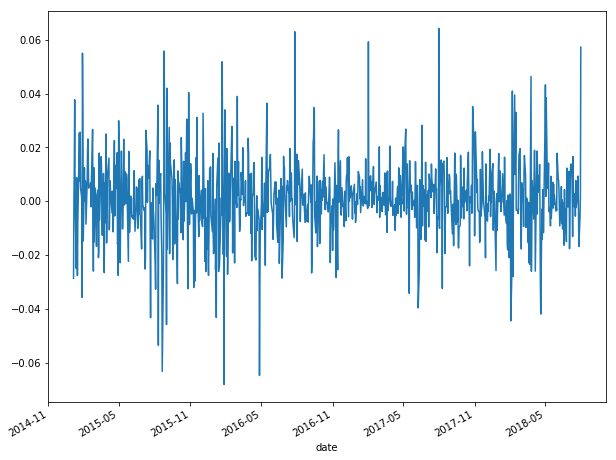

In [75]:
lrets.AAPL.plot(figsize=(10, 8))

best estimated lag order = 1


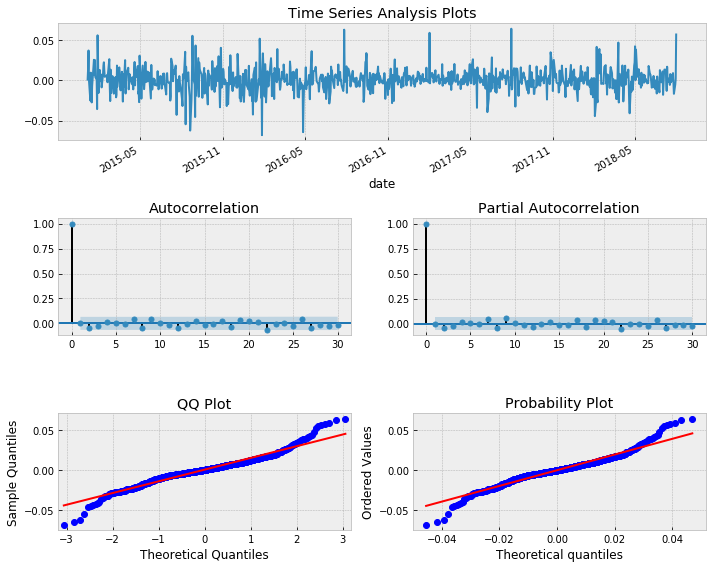

In [78]:
# Select best lag order for SPX returns

max_lag = 30
mdl = smt.AR(lrets.AAPL).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.AAPL).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = %s'%(est_order))

_ = tsplot(mdl.resid, lags=max_lag)

Again we see an AR(1) model, telling us a simple linear model of past prices is not a good fit for AAPL. And running a test for normality on the residuals below, we find that they are not normally distributed either.

In [79]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

We have reason to suspect the residuals are not normally distributed.


## Moving Average Models - MA(q)

MA(q) models are very similar to AR(p) models. MA(q) model is a linear combination of past error terms as opposed to a linear combination of past observations like the AR(p) model. The motivation for the MA model is that we can explain "shocks" in the error process directly by fitting a model to the error terms. (In an AR(p) model these shocks are observed indirectly by using past observations) 

$$x_t=w_t+\beta_1w_{t-1}+…+\beta_qw_{t-q}$$ 

Where $w_t$ is white noise with $E(w_t)=0$ and variance $\sigma^2$

By definition, ACF $ρ_k$ should be zero for k>q.

Let's simulate this process using $\beta$=0.6 and specifying the AR(p) $\alpha$ equal to 0.

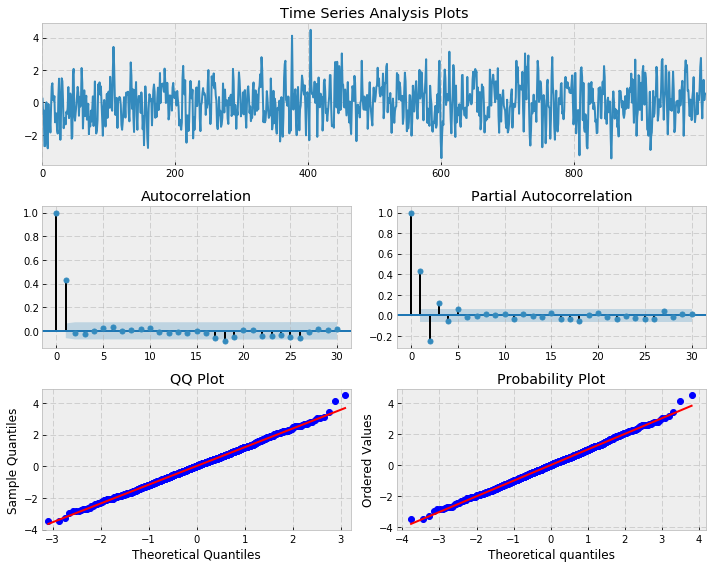

In [54]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

Since q=1, we expect a significant peak at k=1 at ACF and then insignificant peaks subsequent to that. 

Just like we use PACF for AR(p) models, this is a useful way of seeing whether an MA(q) model is appropriate. By taking a look at the ACF of a particular series we can see how many sequential non-zero lags exist. If q such lags exist then we can legitimately attempt to fit a MA(q) model to a particular series.

The ACF function shows that lag 1 is significant which indicates that a MA(1) model may be appropriate for our simulated series. We can now attempt to fit a MA(1) model to our simulated data. 

In [55]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1442.974
Method:                           mle   S.D. of innovations              1.024
Date:                Mon, 27 Feb 2017   AIC                           2889.949
Time:                        21:25:57   BIC                           2899.764
Sample:                             0   HQIC                          2893.679
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5729      0.025     22.791      0.000       0.524       0.622
                                    Roots                                    
                 Real           Imaginary           M

The model was able to correctly estimate the lag coefficent as 0.58 is close to our true value of 0.6. Also notice that our 95% confidence interval does contain the true value. 

In [57]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print 'We have reason to suspect the residuals are not normally distributed.'
else:
    print 'The residuals seem normally distributed.'

The residuals seem normally distributed.


Let's try simulating an MA(3)  process, then try to fit a third order MA model to the series and see if we can recover the correct lag coefficients ($\beta s$). Betas 1-3 are equal to 0.3, 0.2, and 0.1 respectively.
This time we should expect significant peaks at k = {1,2,3}, and insignificant peaks for k>3 in ACF plots.

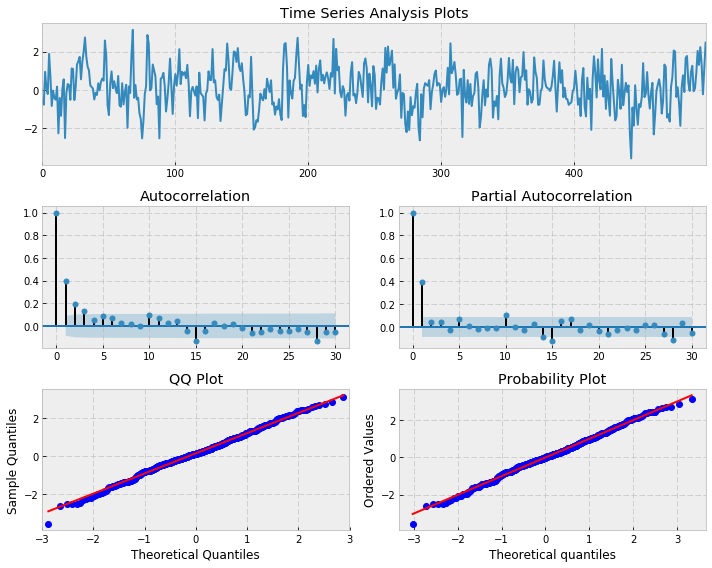

In [58]:
# Simulate MA(3) process with betas 0.3, 0.2, 0.1

n = int(500)
alphas = np.array([0.])
betas = np.array([0.3, 0.2, 0.1])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [59]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  500
Model:                     ARMA(0, 3)   Log Likelihood                -698.240
Method:                           mle   S.D. of innovations              0.978
Date:                Mon, 27 Feb 2017   AIC                           1404.481
Time:                        21:26:34   BIC                           1421.339
Sample:                             0   HQIC                          1411.096
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.3908      0.045      8.729      0.000       0.303       0.479
ma.L2.y        0.1834      0.048      3.826      0.000       0.089       0.277
ma.L3.y        0.1252      0.042      2.993      0.0

In [60]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print 'We have reason to suspect the residuals are not normally distributed.'
else:
    print 'The residuals seem normally distributed.'

The residuals seem normally distributed.


The model was able to estimate the real coefficients effectively. Our 95% confidence intervals also contain the true parameter values of 0.3, 0.2, and 0.1. 

Now let's follow the earlier exercise and fit a MA(1) model to the AAPL log returns and plot residuals again. Keep in mind we do not know the true parameter values.

                              ARMA Model Results                              
Dep. Variable:                   AAPL   No. Observations:                 2015
Model:                     ARMA(0, 1)   Log Likelihood                4841.443
Method:                           mle   S.D. of innovations              0.022
Date:                Mon, 27 Feb 2017   AIC                          -9678.886
Time:                        21:26:48   BIC                          -9667.670
Sample:                    12-29-2006   HQIC                         -9674.769
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.AAPL     0.0026      0.023      0.110      0.912      -0.043       0.048
                                    Roots                                    
                 Real           Imaginary           M

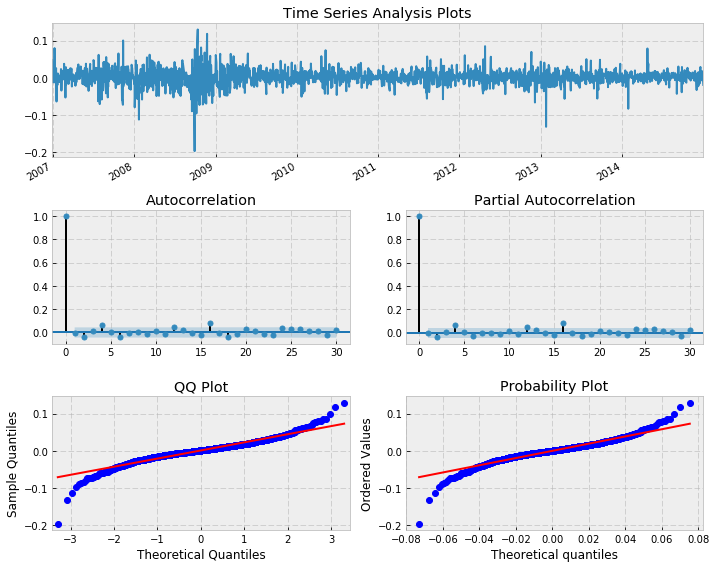

In [61]:
# Fit MA(1) to AAPL log returns

max_lag = 30
Y = lrets.AAPL
mdl = smt.ARMA(Y, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

We see some significant peaks at k=4, k=11 and k=16. Let's try MA(2)

                              ARMA Model Results                              
Dep. Variable:                   AAPL   No. Observations:                 2015
Model:                     ARMA(0, 2)   Log Likelihood                4842.456
Method:                           mle   S.D. of innovations              0.022
Date:                Mon, 27 Feb 2017   AIC                          -9678.912
Time:                        21:26:53   BIC                          -9662.087
Sample:                    12-29-2006   HQIC                         -9672.737
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.AAPL     0.0032      0.022      0.143      0.886      -0.040       0.047
ma.L2.AAPL    -0.0298      0.021     -1.423      0.155      -0.071       0.011
                                    Roots           

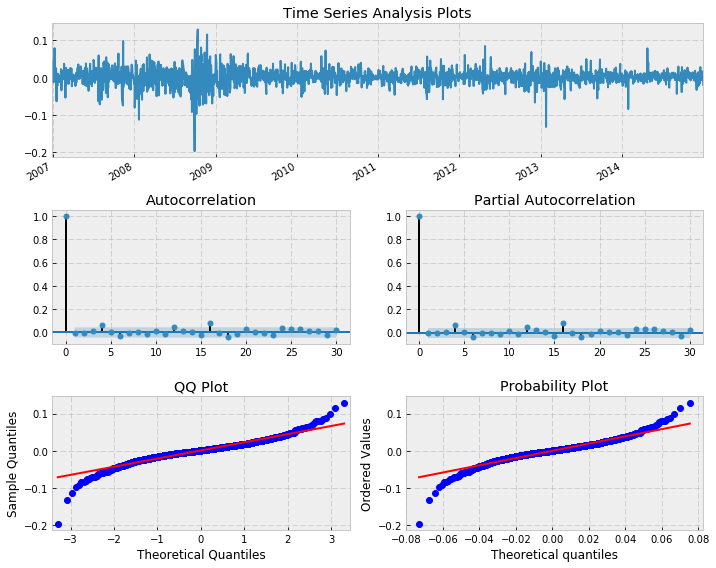

In [62]:
# Fit MA(2) to AAPL log returns

max_lag = 30
Y = lrets.AAPL
mdl = smt.ARMA(Y, order=(0, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

We see marginally significant peaks at k=4, k=16. This is suggestive that the MA(2) model is capturing a lot of the autocorrelation, but not all of the long-memory effects. We could keep increasing the order, but we'd still notice these peaks because we'll be adding a new parameter to a model that has seemingly explained away much of the correlations at shorter lags, but that won't have much of an effect on the longer term lags.

All of this evidence is suggestive of the fact that an MA(q) model is unlikely to be useful in explaining all of the serial correlation in isolation, at least for AAPL.

In [63]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print 'We have reason to suspect the residuals are not normally distributed.'
else:
    print 'The residuals seem normally distributed.'

We have reason to suspect the residuals are not normally distributed.


Let's also try to fit a MA(3) model to the SPX log returns and plot residuals again. 

                              ARMA Model Results                              
Dep. Variable:                    SPX   No. Observations:                 2015
Model:                     ARMA(0, 3)   Log Likelihood                5754.538
Method:                           mle   S.D. of innovations              0.014
Date:                Mon, 27 Feb 2017   AIC                         -11501.075
Time:                        21:07:50   BIC                         -11478.642
Sample:                    12-29-2006   HQIC                        -11492.841
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPX     -0.1193      0.022     -5.366      0.000      -0.163      -0.076
ma.L2.SPX     -0.0515      0.023     -2.246      0.025      -0.096      -0.007
ma.L3.SPX      0.0308      0.022      1.410      0.1

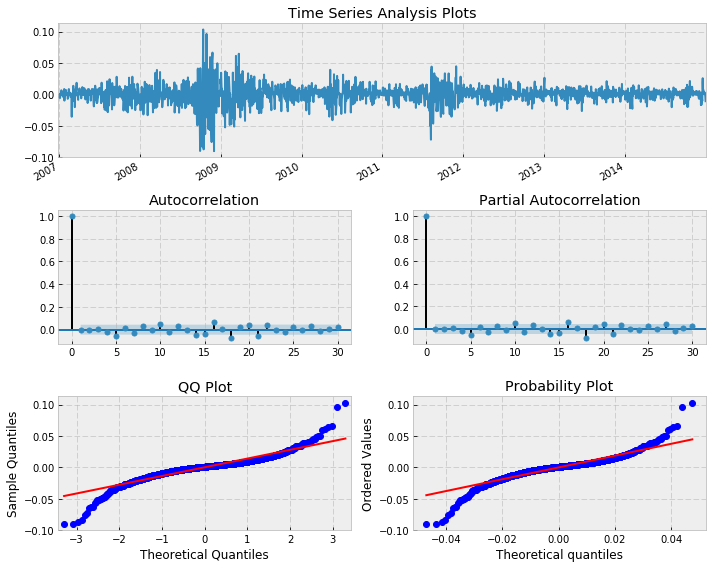

In [50]:
# Fit MA(3) to SPX log returns

max_lag = 30
Y = lrets.SPX
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

We see significant peaks at many longer lags in the residuals. Once again, we find the MA(3) model is not a good fit.

In [64]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print 'We have reason to suspect the residuals are not normally distributed.'
else:
    print 'The residuals seem normally distributed.'

We have reason to suspect the residuals are not normally distributed.


We've now examined two major time series models in detail, namely the Autogressive model of order p, AR(p) and then Moving Average of order q, MA(q). We've seen that they're both capable of explaining away some of the autocorrelation in the residuals of first order differenced daily log prices of equities and indices, but volatility clustering and long-memory effects persist.

It is finally time to turn our attention to the combination of these two models, namely the Autoregressive Moving Average of order p,q, ARMA(p,q) to see if it will improve the situation any further.